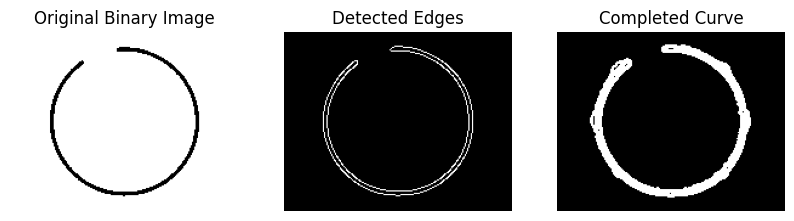

In [6]:
#Completing Incomplete curves
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

def preprocess_image(image_path):
    """Load the image and convert it to grayscale and binary."""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary

def detect_edges(binary_image):
    """Detect edges using Canny edge detection."""
    edges = cv2.Canny(binary_image, 50, 150)
    return edges

def find_endpoints(contour):
    """Find the endpoints of the curve segments."""
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    return np.array([x[0], y[0]]), np.array([x[-1], y[-1]])

def interpolate_curve(contour, start, end):
    """Interpolate the curve between start and end points."""
    # Prepare data for spline fitting
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    points = np.vstack([x, y]).T

    # Interpolate using a spline
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 400)
    x_new, y_new = splev(u_new, tck, der=0)

    # Add the interpolated segment
    new_contour = np.vstack([x_new, y_new]).T
    return np.vstack([points, new_contour])

def main(image_path):
    # Step 1: Preprocess the image
    binary_image = preprocess_image(image_path)

    # Step 2: Detect edges
    edges = detect_edges(binary_image)

    # Step 3: Find the contours (curves) in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("No curves detected.")
        return

    # Assuming we're working with a single curve, take the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Step 4: Identify endpoints
    start, end = find_endpoints(contour)

    # Step 5: Complete the curve by interpolating between the endpoints
    completed_contour = interpolate_curve(contour, start, end)

    # Draw the completed curve on a blank image
    completed_image = np.zeros_like(binary_image)
    cv2.polylines(completed_image, [completed_contour.astype(np.int32)], isClosed=False, color=255, thickness=2)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Binary Image')
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Detected Edges')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Completed Curve')
    plt.imshow(completed_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Run the algorithm on an example image
image_path = 'incomplete_circle.jpg'  # Replace with your image path
main(image_path)
